## Cellpose trained to learn scale

There is much confusion around the cellpose 'diameter' parameter.   As far as I can tell it is simply used to rescale the image with the ratio

```
mean_of_training_diameters/diameter
```

If the training data has a mixture of small and large objects, cellpose can learn these.   This can be shown with a simple simulation.  

In [1]:
import raster_geometry as rg
import numpy as np
from tnia.simulation.phantoms import add_small_to_large_2d
import matplotlib.pyplot as plt
from tnia.plotting.plt_helper import imshow_multi2d
import math

## Make a super simple fake dataset

It only has 2 objects, object 1 with diameter of 6, object 2 with diameter of 140

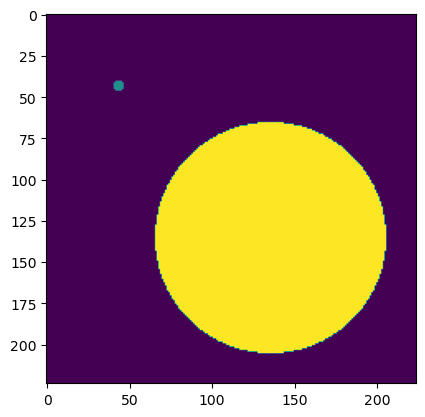

In [22]:
width, height = 224, 224

image = np.zeros([height, width], dtype=np.float32)
truth = np.zeros([height, width], dtype=np.float32)

x, y = 44, 44
r = 3 
size = [math.ceil(r*2), math.ceil(r*2)]
temp=rg.circle(size, r)
add_small_to_large_2d(image, temp, x, y, mode='replace_non_zero')
add_small_to_large_2d(truth, temp, x, y, mode='replace_non_zero')

x, y = 136, 136
r = 70
size = [math.ceil(r*2), math.ceil(r*2)]
temp=rg.circle(size, r)
add_small_to_large_2d(image, temp, x, y, mode='replace_non_zero')
add_small_to_large_2d(truth, 2*temp, x, y, mode='replace_non_zero')

plt.imshow(truth)

## Load Cyto2

We also print the mean diameter of cyto2 (if log is on this will print by default too)

In [29]:
from cellpose import models, io
model_cyto2 = models.CellposeModel(gpu=True, model_type="cyto2")
print('cyto2 diameter mean', model_cyto2.diam_labels)

2024-03-20 05:57:41,692 [INFO] >> cyto2 << model set to be used
2024-03-20 05:57:41,694 [INFO] ** TORCH CUDA version installed and working. **
2024-03-20 05:57:41,696 [INFO] >>>> using GPU
2024-03-20 05:57:41,940 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
cyto2 diameter mean 30.0


## Process with different diameters and cyto2

We try 6, default (which was 30), and 140 (use the same diameters as our 2 objects)

It looks like d=6 finds the small object, d=140 finds the big one, and default finds only the small one. 

Note that the samll object is not the same size between d=6 and default. 

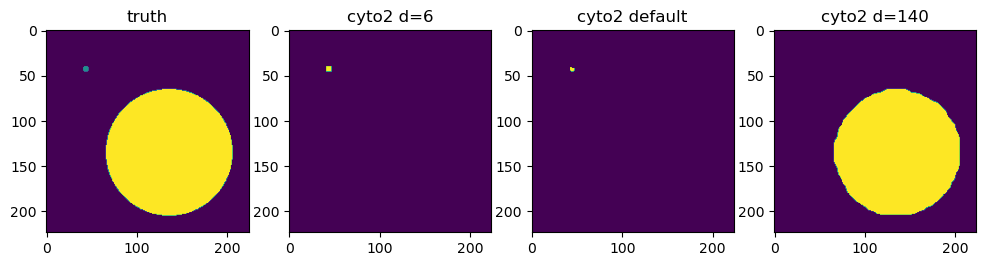

In [30]:
labels_d6 = model_cyto2.eval(truth, channels=[0, 0],diameter=6,flow_threshold=0.8, cellprob_threshold=-0.8)[0]
labels_default = model_cyto2.eval(truth, channels=[0, 0], flow_threshold=0.8, cellprob_threshold=-0.8)[0]
labels_d140 = model_cyto2.eval(truth, channels=[0, 0],diameter=140,flow_threshold=0.8, cellprob_threshold=-0.8)[0]
fig = imshow_multi2d([truth, labels_d6, labels_default, labels_d140], ['truth', 'cyto2 d=6', 'cyto2 default', 'cyto2 d=140'],1 ,4, width = 12, height = 6)


## Repeat the objects to make a fake training set

Just repeat a few times to make a trivial training set.  No need to even add blur or noise, we just want to see if a custom model can learn different scales. 

In [31]:
X = [image.copy().astype('float32')[..., np.newaxis] for i in range(10)]
Y = [truth.copy().astype('uint16') for i in range(10)]

## Make a custom model

In [32]:
import os

model_path = r'./'
model_name = 'custom'
logger = io.logger_setup()
model_custom = models.CellposeModel(gpu=True, model_type=None, pretrained_model=os.path.join(model_path,'models',model_name))

creating new log file
2024-03-20 06:00:53,740 [INFO] WRITING LOG OUTPUT TO C:\Users\bnort\.cellpose\run.log
2024-03-20 06:00:53,742 [INFO] 
cellpose version: 	2.2.3 
platform:       	win32 
python version: 	3.10.13 
torch version:  	2.1.2+cu118
2024-03-20 06:00:53,743 [WARNING] pretrained model has incorrect path
2024-03-20 06:00:53,744 [INFO] >> cyto << model set to be used
2024-03-20 06:00:53,746 [INFO] ** TORCH CUDA version installed and working. **
2024-03-20 06:00:53,746 [INFO] >>>> using GPU
2024-03-20 06:00:54,025 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


## Train our custom model

Note if the log is on it will report the average diameter or the training objects (which should be (6+140)/2=73)

In [33]:
test=model_custom.train(X, Y, 
    channels=[0,1], 
    save_path=model_path, 
    n_epochs=20,
    nimg_per_epoch=10,
    min_train_masks=1,
    model_name=model_name)

2024-03-20 06:01:39,012 [INFO] computing flows for labels


100%|██████████| 10/10 [00:01<00:00,  8.07it/s]

2024-03-20 06:01:40,276 [INFO] >>>> median diameter set to = 30
2024-03-20 06:01:40,277 [INFO] >>>> mean of training label mask diameters (saved to model) 73.160
2024-03-20 06:01:40,278 [INFO] >>>> training network with 2 channel input <<<<
2024-03-20 06:01:40,279 [INFO] >>>> LR: 0.20000, batch_size: 8, weight_decay: 0.00001
2024-03-20 06:01:40,279 [INFO] >>>> ntrain = 10
2024-03-20 06:01:40,280 [INFO] >>>> nimg_per_epoch = 10


2024-03-20 06:01:40,436 [INFO] Epoch 0, Time  0.2s, Loss 0.0671, LR 0.0000
2024-03-20 06:01:40,579 [INFO] saving network parameters to ./models/custom
2024-03-20 06:01:41,210 [INFO] Epoch 5, Time  0.9s, Loss 0.0409, LR 0.1111
2024-03-20 06:01:41,917 [INFO] Epoch 10, Time  1.6s, Loss 0.0104, LR 0.2000
2024-03-20 06:01:43,179 [INFO] saving network parameters to ./models/custom


In [14]:
labels_custom = model_custom.eval(X[0][0,:,:], channels=[0, 1])[0]

## Show all the cyto labels and label custom

Note, cyto can only find objects of different sizes by tuning the ```diameter``` param.  Custom can find very different object sizes by default. 

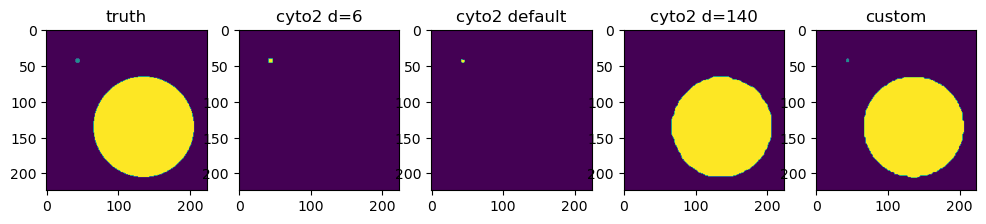

In [35]:
fig = imshow_multi2d([truth, labels_d6, labels_default, labels_d140, labels_custom], ['truth', 'cyto2 d=6', 'cyto2 default', 'cyto2 d=140', 'custom'],1 ,5, width = 12, height = 6)

In [21]:
print(model_custom.diam_labels)
print(model_cyto2.diam_labels)

73.16014584338242
30.0
